## Advanced Lane Lines

The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Compute camera calibration and distortion matrix using chessboard images

In [2]:
def calibrate_camera(images_glob_string):
    """
    Computes camera calibration and distortion matrix for a given set of chessboard images  
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(images_glob_string)
    
    # Get image size
    img= cv2.imread(images[0])
    img_size = (img.shape[1], img.shape[0])

    # Step through the list and search for chessboard corners
    for i, fname in enumerate(images):
        img = cv2.imread(fname)
        img_size = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Compute camera caliberation matrix and distortion coefficients using object and image points of chessboard corners
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return mtx, dist
    

def undistort(img, mtx, dist):
    """
    Undistorts an image using the given caliberation matrix and distortion coefficient
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

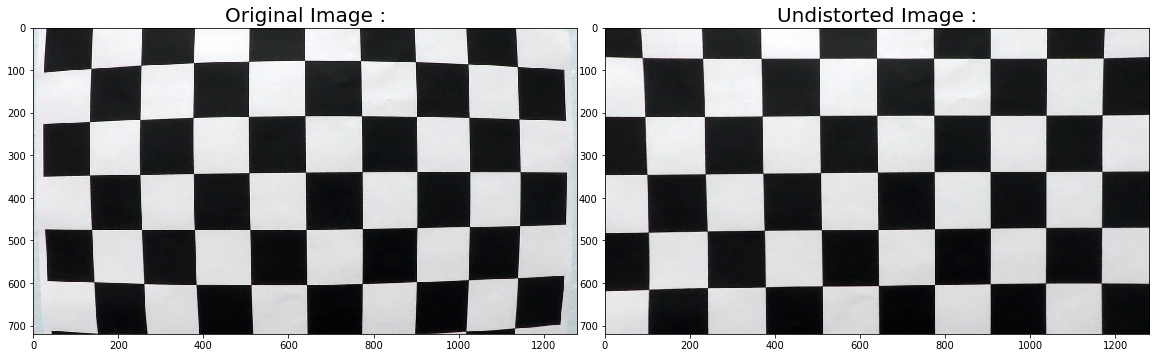

In [3]:
# Visualise undistortion on a test image

chessboard_images_glob_string = './camera_cal/calibration*.jpg'
mtx, dist = calibrate_camera(chessboard_images_glob_string)

img = cv2.imread('./camera_cal/calibration1.jpg')
undistorted_image = undistort(img, mtx, dist)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image :', fontsize=20)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image :', fontsize=20)

### Apply distortion correction to raw images

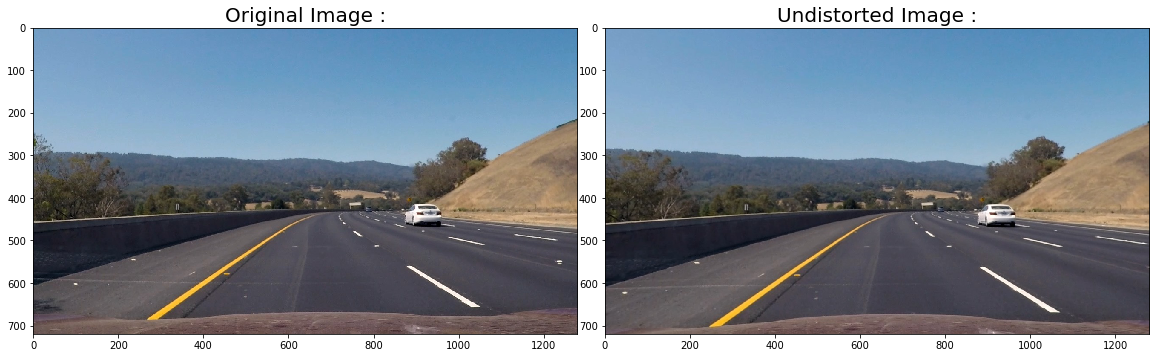

In [4]:
# Load a test image to demonstrate distortion correction
test_image = cv2.imread('./test_images/test3.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
undistorted_test_image = undistort(test_image, mtx, dist)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_image)
ax1.set_title('Original Image :', fontsize=20)
ax2.imshow(undistorted_test_image)
ax2.set_title('Undistorted Image :', fontsize=20)

### Filter lane pixels applying color and gradient thresholding

In [26]:
def mag_thresh(img, sobel_kernel=15, mag_thresh=(25, 255)):
    """
    Computes magnitude of gradient using sobel x and y operators  and 
    returns a binary mask satisfying magnitude threshold on the given image
    """
    # Apply the following steps to img
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # Return this mask as your binary_output image
    binary_output = np.copy(sxbinary) 
    return binary_output

def dir_thresh(img, sobel_kernel=15, thresh=(0, 0.09)):    
    """
    Computes direction of gradient using sobel x and y operators  and 
    returns a binary mask satisfying magnitude threshold on the given image
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return binary_output

def color_thresh(img):
    """
    Returns a binary mask for yellow and white pixels on the given image
    """
    # Pick white using L channel from HLS Colorspace
    new_img = np.copy(img)
    hls = cv2.cvtColor(new_img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))

        
    # Pick yellow using B channel from LAB Colorpace
    new_img = np.copy(img)
    lab = cv2.cvtColor(new_img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
        
    # Apply thresholds  
    binary_output = np.zeros_like(img[:, :, 0])
    binary_output[(((lab_b > 190) & (lab_b <= 255))|((hls_l > 220) & (hls_l <= 255)))] = 1
    return binary_output

def combined_threshold(img):
    """
    Returns a binary mask satisfying color and gradient threshold on the given image
    """
    
    sobel_kernel = 15
    dir_min = 0.7
    dir_max = 1.2
    mag_min = 50
    mag_max = 255
   
    direc = dir_thresh(img, sobel_kernel=sobel_kernel, thresh=(dir_min, dir_max))
    mag = mag_thresh(img, sobel_kernel=sobel_kernel, mag_thresh=(mag_min, mag_max))
    color = color_thresh(img)

    combined = np.zeros_like(direc)
    combined[((color == 1) & ((mag == 1) | (direc == 1)))] = 1

    return combined

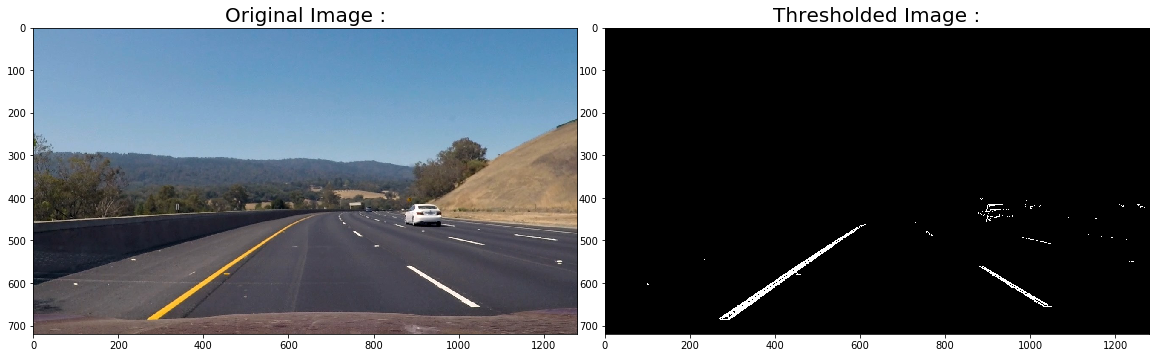

In [27]:
# Load a test image to demonstrate thresholding
test_image = cv2.imread('./test_images/test3.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
thresholded_test_image = combined_threshold(test_image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_image)
ax1.set_title('Original Image :', fontsize=20)
ax2.imshow(thresholded_test_image,cmap = 'gray')
ax2.set_title('Thresholded Image :', fontsize=20)

### Apply a perspective transform to rectify binary image ("birds-eye view").

In [28]:
class ImageWarper:
    def __init__(self, src, dst):
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)

    def warp(self, img):
        """
        Warps image perspective from source to destination
        """
        return cv2.warpPerspective(
            img,
            self.M,
            (img.shape[1], img.shape[0]),
            flags=cv2.INTER_LINEAR
        )

    def unwarp(self, img):
        """
        Unwarps image perspective from destination to src
        """
        return cv2.warpPerspective(
            img,
            self.Minv,
            (img.shape[1], img.shape[0]),
            flags=cv2.INTER_LINEAR
        )

(720, 1280, 3)


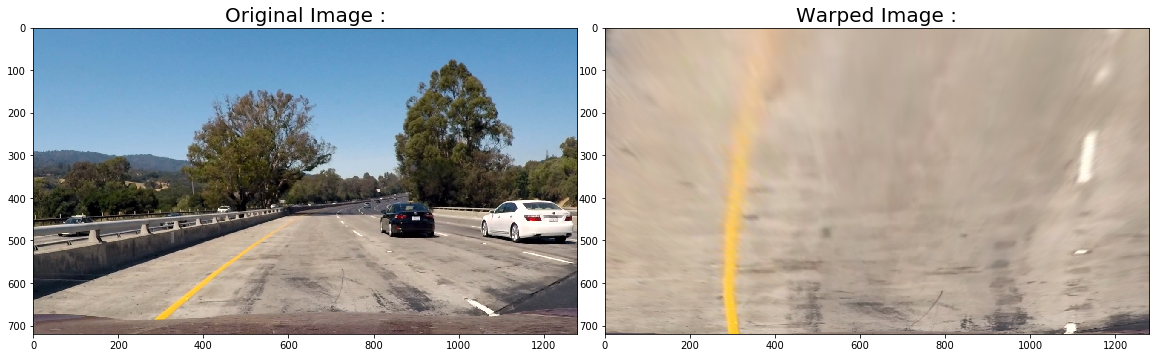

In [29]:
# Load a test image to demonstrate perspective transformation
src = np.float32([
            [260, 680],
            [580, 460],
            [700, 460],
            [1020, 680],
          
        ])

dest = np.float32([
            [260, 720],
            [260, 0],
            [1020, 0],
            [1020, 720],
         
        ])

image_warper = ImageWarper(src, dest)

test_image = cv2.imread('./test_images/test1.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
print(test_image.shape)
warped_test_image = image_warper.warp(test_image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_image)
ax1.set_title('Original Image :', fontsize=20)
ax2.imshow(warped_test_image,cmap = 'gray')
ax2.set_title('Warped Image :', fontsize=20)

### Detect lane pixels and fit to find the lane boundary.

In [30]:
class LaneFinder:
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.left_lane_inds = None
        self.right_lane_inds = None

    def polyfit(self, img):
        
        # If prev frame fit is not available, commpute left and right lane fit using sliding windows
        if self.left_fit is None or self.right_fit is None:
            left_fit, right_fit, left_lane_inds, right_lane_inds, bboxes, histogram = self.sliding_window_polyfit(img)
            self.left_fit = left_fit
            self.right_fit = right_fit
            self.left_lane_inds = left_lane_inds
            self.right_lane_inds = right_lane_inds
            return self.left_fit, self.right_fit, self.left_lane_inds, self.right_lane_inds

        nonzero =  img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        self.left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + 
        self.left_fit[2] - margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + 
        self.left_fit[1]*nonzeroy + self.left_fit[2] + margin))) 

        self.right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + 
        self.right_fit[2] - margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + 
        self.right_fit[1]*nonzeroy + self.right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[self.left_lane_inds]
        lefty = nonzeroy[self.left_lane_inds] 
        rightx = nonzerox[self.right_lane_inds]
        righty = nonzeroy[self.right_lane_inds]
        # Fit a second order polynomial to each        
        if len(leftx) != 0:
            # Fit a second order polynomial to each
            self.left_fit = np.polyfit(lefty, leftx, 2)
        if len(rightx) != 0:
            self.right_fit = np.polyfit(righty, rightx, 2)
            
        return self.left_fit, self.right_fit, self.left_lane_inds, self.right_lane_inds
            
        

    def measure_curvature(self, img):
        """
        Computes radius of curvature of the extracted lines 
        """
        ploty = np.linspace(0, 719, num=720)  # to cover same y-range as image
        quadratic_coeff = 3e-4  # arbitrary quadratic coefficient
        leftx = np.array([200 + (y ** 2) * quadratic_coeff + np.random.randint(-50, high=51)
                          for y in ploty])
        rightx = np.array([900 + (y ** 2) * quadratic_coeff + np.random.randint(-50, high=51)
                           for y in ploty])

        leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
        rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

        y_eval = np.max(ploty)
 
        ym_per_pix = 30 / 720  # meters per pixel in y dimension
        xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

        left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
            2 * left_fit_cr[0])
        right_curverad = (
                             (1 + (
                                 2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[
                                     1]) ** 2) ** 1.5) / np.absolute(
            2 * right_fit_cr[0])
  
        ratio = left_curverad / right_curverad
        if ratio < 0.66 or ratio > 1.5:
            print('Warning: shitty ratio {}'.format(ratio))

        lane_leftx = self.left_fit[0] * (img.shape[0] - 1) ** 2 + self.left_fit[1] * (img.shape[0] - 1) + self.left_fit[2]
        lane_rightx = self.right_fit[0] * (img.shape[0] - 1) ** 2 + self.right_fit[1] * (img.shape[0] - 1) + self.right_fit[2]

        vehicle_position = ((img.shape[1] / 2) - ((lane_leftx + lane_rightx) / 2)) * xm_per_pix

        return (left_curverad + right_curverad) / 2, vehicle_position.round(2)
    
 
    def sliding_window_polyfit(self, img):
        """
        Computes a ploynomial fit to the extracted lines in given binary image using sliding windows
        """
        # Take a histogram of the bottom half of the image
        histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(img.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 80
        # Set minimum number of pixels found to recenter window
        minpix = 30
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        # Rectangle data for visualization
        bboxes = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            bboxes.append((((win_xleft_low,win_y_low),(win_xleft_high,win_y_high)),((win_xright_low,win_y_low),(win_xright_high,win_y_high))))
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        left_fit, right_fit = (None, None)
        # Fit a second order polynomial to each
        if len(leftx) != 0:
            left_fit = np.polyfit(lefty, leftx, 2)
        if len(rightx) != 0:
            right_fit = np.polyfit(righty, rightx, 2)

        return left_fit, right_fit, left_lane_inds, right_lane_inds, bboxes, histogram

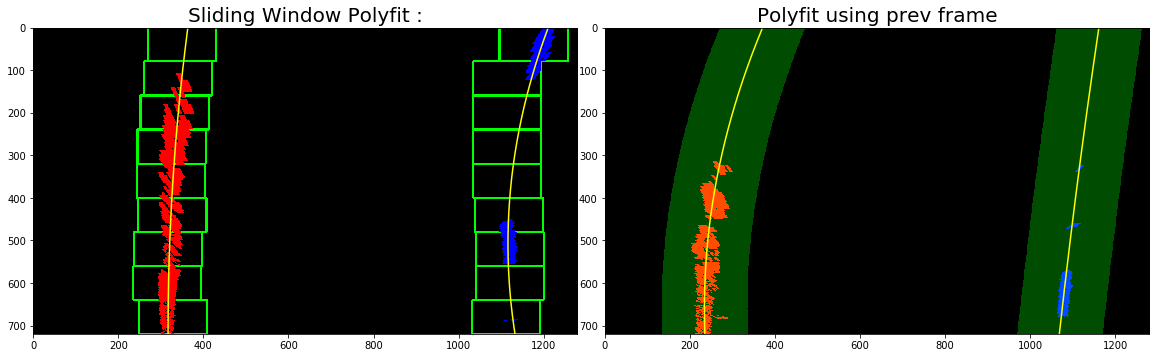

In [38]:
# Visualising lane fidning processing 

# Load first image, the lane finder would process this image with sliding window ployfit
test_image = cv2.imread('./test_images/test4.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

undistorted_test_image = undistort(test_image, mtx, dist)
thresholded_test_image = combined_threshold(undistorted_test_image)
image_warper = ImageWarper(src, dest)
warped_test_image = image_warper.warp(thresholded_test_image)

# Create an output image to draw on and  visualize the result
nonzero = warped_test_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img = np.zeros_like(test_image)

# Compute left and right lane fit
lane_finder = LaneFinder()
left_fit, right_fit, left_lane_inds, right_lane_inds, bboxes, histogram = lane_finder.sliding_window_polyfit(warped_test_image)

# Draw the sliding window boxes
for bbox in bboxes:
    cv2.rectangle(out_img,(bbox[0][0][0],bbox[0][0][1]),(bbox[0][1][0],bbox[0][1][1]),(0,255,0), 3) 
    cv2.rectangle(out_img,(bbox[1][0][0],bbox[1][0][1]),(bbox[1][1][0],bbox[1][1][1]),(0,255,0), 3) 

# Generate x and y values for plotting
ploty = np.linspace(0, warped_test_image.shape[0]-1, warped_test_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(out_img)
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')
ax1.set_title('Sliding Window Polyfit :', fontsize=20)

# Load the second image, lane finder would be using the prev fit information to process this image

test_image_2 = cv2.imread('./test_images/test5.jpg')
test_image_2 = cv2.cvtColor(test_image_2, cv2.COLOR_BGR2RGB)

undistorted_test_image_2 = undistort(test_image_2, mtx, dist)
thresholded_test_image_2 = combined_threshold(undistorted_test_image_2)
warped_test_image_2 = image_warper.warp(thresholded_test_image_2)

left_fit, right_fit, left_lane_inds, right_lane_inds = lane_finder.polyfit(warped_test_image_2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped_test_image.shape[0]-1, warped_test_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an output image to draw on and  visualize the result
nonzero = warped_test_image_2.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img_2 = np.zeros_like(test_image_2)
window_img_2 = np.zeros_like(test_image_2)

# Color in left and right line pixels
out_img_2[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img_2[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

margin=100
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img_2, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img_2, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img_2, 1, window_img_2, 0.3, 0)
ax2.imshow(result)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.set_title('Polyfit using prev frame', fontsize=20)

In [39]:
def draw_lane(original_img, binary_img, l_fit, r_fit, image_warper):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp =image_warper.unwarp(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

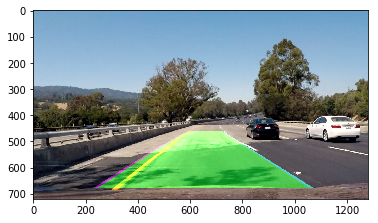

In [40]:
result = draw_lane(test_image, warped_test_image , left_fit, right_fit, image_warper)
plt.imshow(result)

### Create a lane detection pipeline putting it all together

In [41]:
lane_finder = LaneFinder()
image_warper = ImageWarper(src, dest)

def lane_detection_pipeline(img):
    undistorted_img = undistort(img, mtx, dist)
    thresholded_img = combined_threshold(undistorted_img)
    warped_img = image_warper.warp(thresholded_img)
    left_fit, right_fit, left_lane_inds, right_lane_inds = lane_finder.polyfit(warped_img)
    lane_curvature, vehicle_position = lane_finder.measure_curvature(warped_img)
    result = draw_lane(undistorted_img, warped_img , left_fit, right_fit, image_warper)
    
    # Transpose vehicle and curvature details on result
    if vehicle_position > 0:
        vehicle_position_text = '{}m right of center'.format(vehicle_position)
    else:
        vehicle_position_text = '{}m left of center'.format(abs(vehicle_position))

    cv2.putText(result, "Lane Curvature: {}m".format(lane_curvature.round()), (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1,
                color=(255, 255, 255), thickness=2)
    cv2.putText(result, "Vehicle Position: {}".format(vehicle_position_text), (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, color=(255, 255, 255),
                thickness=2)
    
    return result

In [42]:
video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
processed_video = video_input.fl_image(lane_detection_pipeline)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  7%|▋         | 86/1261 [00:15<03:33,  5.50it/s]

  8%|▊         | 98/1261 [00:17<03:31,  5.49it/s]

 24%|██▎       | 298/1261 [00:54<02:57,  5.43it/s]

 73%|███████▎  | 923/1261 [02:49<01:03,  5.32it/s]

100%|█████████▉| 1260/1261 [22:29<00:00,  3.17it/s]   


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 35s, sys: 50.6 s, total: 5min 25s
Wall time: 22min 30s
